## Method D - Unique Contribution: Ensemble Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from ecgLoader import load_ecg5000
from tensorflow.keras import layers, models, Input

X_train, X_test, y_train, y_test = load_ecg5000(one_hot=True)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]



Applied one-hot encoding: (3998, 5)


In [2]:
def attention_block(inputs):
    attention = layers.Dense(1, activation='tanh')(inputs)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(inputs.shape[-1])(attention)
    attention = layers.Permute([2, 1])(attention)
    return layers.Multiply()([inputs, attention])

def build_cnn_attention_model(input_shape=(140, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = attention_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv1D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv1D(filters, kernel_size=1, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_model(input_shape=(140, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [3]:
modelA = build_cnn_attention_model()
modelB = build_resnet_model()

print("Training CNN + Attention (Method A)...")
modelA.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=64)

print("Training Improved ResNet (Method B)...")
modelB.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=64)


Training CNN + Attention (Method A)...
Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8463 - loss: 1.0610 - val_accuracy: 0.9750 - val_loss: 0.1201
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9792 - loss: 0.0702 - val_accuracy: 0.9812 - val_loss: 0.0865
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9847 - loss: 0.0586 - val_accuracy: 0.9725 - val_loss: 0.0848
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9788 - loss: 0.0670 - val_accuracy: 0.9787 - val_loss: 0.0715
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9844 - loss: 0.0541 - val_accuracy: 0.9787 - val_loss: 0.0677
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9875 - loss: 0.0411 - val_accuracy: 0.9812 - val_loss: 0.0564
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9869 - loss: 0.0435 - val_accuracy: 0.9787 - val_loss: 0.0645
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9926 - 

In [4]:
y_pred_A = modelA.predict(X_test)
y_pred_B = modelB.predict(X_test)

ensemble_probs = (y_pred_A + y_pred_B) / 2.0
ensemble_preds = np.argmax(ensemble_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       591
           4       1.00      0.98      0.99       409

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



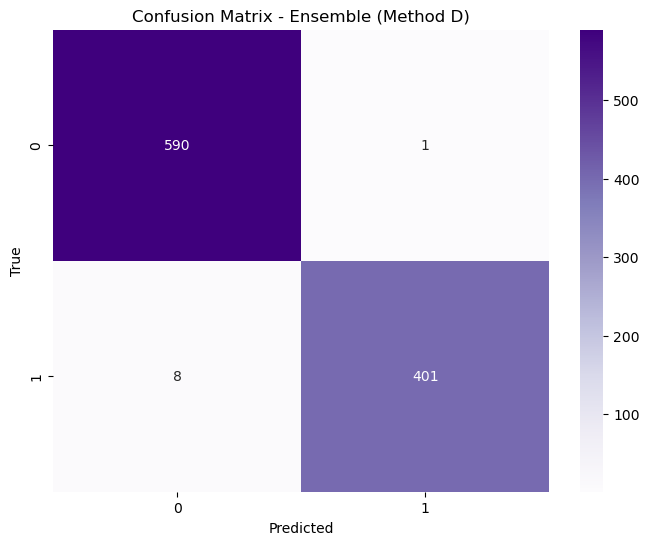

In [5]:
# Classification Report
print(classification_report(y_true, ensemble_preds))

# Confusion Matrix
cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble (Method D)')
plt.show()


## Let's try another dataset

In [6]:
from ecgLoader import load_heartbeat_dataset

X_train, X_test, y_train, y_test = load_heartbeat_dataset(one_hot=True)
print(X_train.shape, y_train.shape)

(87556, 187, 1) (87556, 5)


In [7]:
def build_cnn_attention_model_heartbeat(input_shape=(187, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=5, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = attention_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_resnet_model_heartbeat(input_shape=(187, 1), num_classes=5):
    inputs = Input(shape=input_shape)
    x = layers.Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 128)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
model_a = build_cnn_attention_model_heartbeat(input_shape=(187, 1), num_classes=5)
model_b = build_resnet_model_heartbeat(input_shape=(187, 1), num_classes=5)


history_a = model_a.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)
history_b = model_b.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=64)

y_pred_a = model_a.predict(X_test)
y_pred_b = model_b.predict(X_test)

ensemble_probs = (y_pred_a + y_pred_b) / 2.0
ensemble_preds = np.argmax(ensemble_probs, axis=1)
y_true = np.argmax(y_test, axis=1)


Epoch 1/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 87s 57ms/step - accuracy: 0.8926 - loss: 0.4201 - val_accuracy: 0.9587 - val_loss: 0.1598
Epoch 2/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - accuracy: 0.9600 - loss: 0.1478 - val_accuracy: 0.9650 - val_loss: 0.1356
Epoch 3/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9670 - loss: 0.1203 - val_accuracy: 0.9683 - val_loss: 0.1216
Epoch 4/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.9725 - loss: 0.1012 - val_accuracy: 0.9730 - val_loss: 0.0999
Epoch 5/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.9747 - loss: 0.0919 - val_accuracy: 0.9752 - val_loss: 0.0911
Epoch 6/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 66s 60ms/step - accuracy: 0.9773 - loss: 0.0807 - val_accuracy: 0.9753 - val_loss: 0.0905
Epoch 7/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 74s 67ms/step - accuracy: 0.9792 - loss: 0.0739 - val_accuracy: 0.9773 - val_loss: 0.0818
Epoch 8/10
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 78s 71ms/step - accuracy: 0.9800 -


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18160
           1       0.96      0.71      0.82       535
           2       0.96      0.96      0.96      1402
           3       0.94      0.70      0.80       158
           4       0.99      0.98      0.99      1635

    accuracy                           0.98     21890
   macro avg       0.97      0.87      0.91     21890
weighted avg       0.98      0.98      0.98     21890



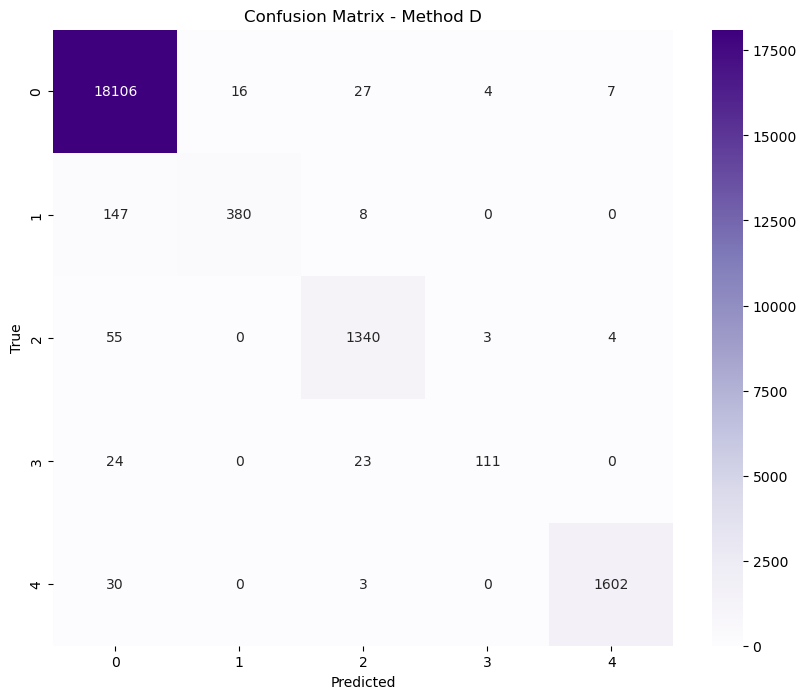

In [9]:
report = classification_report(y_true, ensemble_preds)
conf_matrix = confusion_matrix(y_true, ensemble_preds)



print("\nClassification Report:")
print(report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.title(f'Confusion Matrix - Method D')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()